# Final competition of Deep Learning 2020 Spring
Traffic environment semi-supervised Learning Contest

## Goals
The objective is to train a model using images captured by six different cameras attached to the same car to generate a top down view of the surrounding area. The performance of the model will be evaluated by (1) the ability of detecting objects (like car, trucks, bicycles, etc.) and (2) the ability to draw the road map layout.

## Data
You will be given two sets of data:

 1. Unlabeled set: just images
 2. Labeled set: images and the labels(bounding box and road map layout)

This notebook will help you understand the dataset.

In [1]:
import os
import time
import sys
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from sklearn.metrics import confusion_matrix

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../../DLSP20Dataset/data'
annotation_csv = '../../DLSP20Dataset/data/annotation.csv'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

False

In [6]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def order_points(pts):
    from scipy.spatial import distance as dist
    import numpy as np
    
    xSorted = pts[np.argsort(pts[:, 0]), :]

    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    return np.array([tl, tr, br, bl], dtype="float32")

def arrange_box(x1,y1):
    box=np.array(list(zip(x1,y1)))
    box=order_points(box)
    return box

def iou(box1, box2):
    from shapely.geometry import Polygon
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area

#def iou(xy1,xy2):
#    
#    from shapely.geometry import Polygon
#    
#    boxA = Polygon(arrange_box(xy1[0],xy1[1])).buffer(1e-9)
#    boxB = Polygon(arrange_box(xy2[0],xy2[1])).buffer(1e-9)
#    
#    try:
#        return boxA.intersection(boxB).area / boxA.union(boxB).area
#    except:
#        print('Box 1:',xy1[0],xy1[1])
#        print('Box 2:',xy2[0],xy2[1])
#        sys.exit(1)

In [7]:
def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def calculate_overlap(target_bb, predicted_bb):
    overlaps = torch.zeros(target_bb.size(0),predicted_bb.size(0))

    for j in range(overlaps.shape[0]):
        for k in range(overlaps.shape[1]):
            overlaps[j][k] = iou(target_bb[j],predicted_bb[k])
            
    return overlaps

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

In [8]:
from skimage import draw
import numpy as np

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = torch.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

def convert_to_binary_mask(corners, shape=(800,800)):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    x,y = point_squence.T[0].detach() * 10 + 400, -point_squence.T[1].detach() * 10 + 400
    new_im = poly2mask(y, x, shape)
    return new_im

In [9]:
def create_conf_matrix(target, pred, debug=True):
    import sys
    
    target = target.reshape(-1)
    pred = pred.reshape(-1)
    
    if debug:
        print('Target values:', target.unique())
        print('Predicted values:', pred.unique())
        print('Target shape:', target.shape)
        print('Predicted shape:', pred.shape)
    
    nb_classes = max(target.unique())
    if len(pred.unique()) > (nb_classes+1) :
        print('More predicted classes than true classes')
        sys.exit(1)
        
    conf_matrix = torch.zeros(nb_classes+1, nb_classes+1)
    for t, p in zip(target, pred):
        conf_matrix[t, p] += 1
    
    return conf_matrix

In [10]:
def create_conf_matrix2(target, pred, debug=True):
    import sys
    
    target = target.reshape(-1).cpu().numpy()
    pred = pred.reshape(-1).cpu().numpy()
    
        
    conf_matrix = torch.from_numpy(confusion_matrix(target, pred)).to(device)
    
    return conf_matrix

In [11]:
def classScores(conf_matrix):
    print('Confusion matrix\n', conf_matrix)
    TP = conf_matrix.diag()
    TN = torch.zeros_like(TP)
    FP = torch.zeros_like(TP)
    FN = torch.zeros_like(TP)
    for c in range(conf_matrix.size(0)):
        idx = torch.ones(conf_matrix.size(0)).byte()
        idx[c] = 0
        # all non-class samples classified as non-class
        TN[c] = conf_matrix[idx.nonzero()[:, None], idx.nonzero()].sum() #conf_matrix[idx[:, None], idx].sum() - conf_matrix[idx, c].sum()
        # all non-class samples classified as class
        FP[c] = conf_matrix[idx, c].sum()
        # all class samples not classified as class
        FN[c] = conf_matrix[c, idx].sum()

        print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(
            c, TP[c], TN[c], FP[c], FN[c]))
        
    return TP, TN, FP, FN

# Dataset

You will get two different datasets:

 1. an unlabeled dataset for pre-training
 2. a labeled dataset for both training and validation
 
## The dataset is organized into three levels: scene, sample and image

 1. A scene is 25 seconds of a car's journey.
 2. A sample is a snapshot of a scene at a given timeframe. Each scene will be divided into 126 samples, so about 0.2 seconds between consecutive samples.
 3. Each sample contains 6 images captured by camera facing different orientation.
    Each camera will capture 70 degree view. To make it simple, you can safely assume that the angle between the cameras is 60 degrees 

106 scenes in the unlabeled dataset and 28 scenes in the labeled dataset

In [12]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [13]:
train_scene_index = np.random.choice(labeled_scene_index, int(np.ceil(0.8*len(labeled_scene_index))))

In [14]:
test_scene_index = labeled_scene_index[np.isin(labeled_scene_index, train_scene_index,invert=True)]

# Unlabeled dataset

You get two ways to access the dataset, by sample or by image

In [76]:
intrinsics = {'CAM_FRONT_LEFT': [[879.03824732, 0.0, 613.17597314],
[0.0, 879.03824732, 524.14407205],
[0.0, 0.0, 1.0]],
'CAM_FRONT': [[882.61644117, 0.0, 621.63358525],
[0.0, 882.61644117, 524.38397862],
[0.0, 0.0, 1.0]],
'CAM_FRONT_RIGHT': [[880.41134027, 0.0, 618.9494972],
[0.0, 880.41134027, 521.38918482],
[0.0, 0.0, 1.0]],
'CAM_BACK_LEFT': [[881.28264688, 0.0, 612.29732111],
[0.0, 881.28264688, 521.77447199],
[0.0, 0.0, 1.0]],
'CAM_BACK': [[882.93018422, 0.0, 616.45479905],
[0.0, 882.93018422, 528.27123027],
[0.0, 0.0, 1.0]],
'CAM_BACK_RIGHT': [[881.63835671, 0.0, 607.66308183],
[0.0, 881.63835671, 525.6185326],
[0.0, 0.0, 1.0]]}

In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_H = 223
IMAGE_W = 1280

src = np.float32([[0, IMAGE_H], [1207, IMAGE_H], [0, 0], [IMAGE_W, 0]])
dst = np.float32([[569, IMAGE_H], [711, IMAGE_H], [0, 0], [IMAGE_W, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

In [96]:
M

array([[ 1.        , 21.68834081,  0.        ],
       [ 0.        ,  8.5       ,  0.        ],
       [-0.        ,  0.03363229,  1.        ]])

## Get Sample

In [15]:
#transform = torchvision.transforms.ToTensor()

transform=torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                          torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=16, shuffle=True, num_workers=2)

In [89]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([16, 6, 3, 256, 306])


In [90]:
sample[0][1].shape

torch.Size([3, 256, 306])

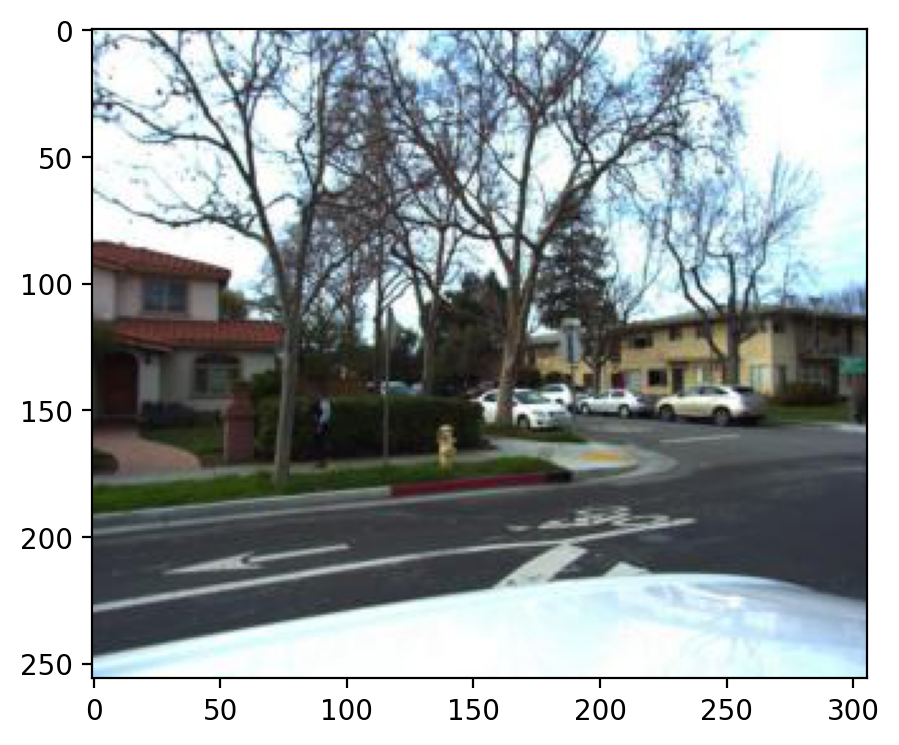

In [92]:
plt.imshow(sample[0,0,:,:,:].numpy().transpose(1, 2, 0))

In [106]:
images = [y.transpose(1, 2, 0) for y in sample[:,0,:,:,:].numpy()]

In [129]:
import cv2
import glob
import numpy as np
Nx_cor = 2 # Number of corners to find
Ny_cor = 3
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((Nx_cor*Ny_cor,3), np.float32)
objp[:,:2] = np.mgrid[0:Nx_cor, 0:Ny_cor].T.reshape(-1,2)
srcs = [] # 3d points in real world space
dsts = [] # 2d points in image plane.
#images = glob.glob('path/to/calibration/images') # Make a list of paths to calibration images
# Step through the list and search for chessboard corners
corners_not_found = [] # Calibration images in which OpenCV failed to find corners
for idx, img in enumerate(images):
    #img = cv2.imread(fname)
    gray = cv2.cvtColor(np.float32((255*img/np.max(img)).astype(np.uint8)), cv2.COLOR_BGR2GRAY) # Conver to grayscale
    #ret, corners = cv2.findChessboardCorners(gray, (Nx_cor,Ny_cor), None) # Find the corners
    dst = cv2.cornerHarris(gray, 2,3, 0.04) # Find the corners
    # If found, add object points, image points
    srcs.append(gray)
    dsts.append(dst)

In [127]:
dst.shape

(256, 306)

In [132]:
src = srcs[0]
dst = dsts[0]
M = cv2.getPerspectiveTransform(src, dst) 

warped_img = cv2.warpPerspective(src, 
                                 M, (256, 306)) # Image warping
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results

error: OpenCV(4.2.0) ../modules/imgproc/src/imgwarp.cpp:3391: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'


In [87]:
torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0).shape

(518, 776, 3)

In [18]:
class Encoder1(nn.Module):
    def __init__(self,n_feature, hidden):
        super(Encoder1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                           out_channels=n_feature, 
                           kernel_size=(3,5), 
                           stride=2)
        self.maxp1 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        
        self.conv2 = nn.Conv2d(in_channels=n_feature, 
                               out_channels=64, 
                               kernel_size=(3,5), 
                               stride=1,
                               padding=(0,0))
        self.maxp2 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(3,3), 
                               stride=1,
                               padding=(0,0))
        self.maxp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv3_bn = nn.BatchNorm2d(96)
        
        self.lin1 = nn.Linear(96*14*16,hidden)
        self.lin1_bn = nn.BatchNorm1d(hidden)
        
    def forward(self, x, verbose=False):
        x = F.relu(self.conv1_bn(self.maxp1(self.conv1(x))))
        x = F.relu(self.conv2_bn(self.maxp1(self.conv2(x))))
        x = F.relu(self.conv3_bn(self.maxp1(self.conv3(x))))
        x = F.relu(self.lin1_bn(self.lin1(x.reshape(-1,96*14*16))))
        return x

In [19]:
class Decoder1(nn.Module):
    def __init__(self, hidden, hidden_img):
        super(Decoder1, self).__init__()
        self.hidden_img = hidden_img

        self.lin1 = nn.Linear(hidden,3*hidden_img*int(1.2*(hidden_img)))
        self.lin1_bn = nn.BatchNorm1d(3*hidden_img*int(1.2*(hidden_img)))

        self.convT1 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (3,4),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))
        
        self.convT1_bn = nn.BatchNorm2d(3)

        self.convT2 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (3,3),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))
        
        self.convT2_bn = nn.BatchNorm2d(3)

        self.convT3 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (2,1),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(1,1))
        
    def forward(self, x, verbose=False):
        x = F.relu(self.lin1_bn(self.lin1(x)).reshape(-1,3,self.hidden_img,int(1.2*self.hidden_img)))
        x = self.convT3(
            self.convT2_bn(self.convT2(
            self.convT1_bn(self.convT1(x)))))
        x = tuple(x)
        x = torch.stack(x)
        return x

In [69]:
class ConvLayer(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 bias = True, 
                 pool=False,
                 mp_kernel_size=2, 
                 mp_stride=2):
        super(ConvLayer, self).__init__()
        if pool:
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU(), 
                nn.MaxPool2d(kernel_size=mp_kernel_size, stride=mp_stride))
        else:
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU(), 
                )
        
    def forward(self, x):
        return self.layer(x)

class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearLayer, self).__init__()
        self.layer = nn.Sequential(
            torch.nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(0.5),
            nn.LeakyReLU(negative_slope=0.1) ## nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer(x)

class ConvTLayer(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 output_padding=0, 
                 unpool=False,
                 mp_kernel_size=2, 
                 mp_stride=2):
        super(ConvTLayer, self).__init__()
        if unpool:
            self.layer = nn.Sequential(
                nn.ConvTranspose2d(in_channels, 
                                   out_channels, 
                                   kernel_size, 
                                   stride=stride, 
                                   padding=padding, 
                                   output_padding=output_padding, 
                                   bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU()
                nn.MaxUnpool2d(kernel_size=mp_kernel_size, stride=mp_stride)
            )
        else:
            self.layer = nn.Sequential(
                nn.ConvTranspose2d(in_channels, 
                                   out_channels, 
                                   kernel_size, 
                                   stride=stride, 
                                   padding=padding, 
                                   output_padding=output_padding, 
                                   bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU()
            )        
    def forward(self, x):
        return self.layer(x)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = ConvLayer(3,16)
        self.conv2 = ConvLayer(96,128)
        self.conv3 = ConvLayer(128,256)
        self.conv4 = ConvLayer(256,512)
        self.conv5 = ConvLayer(512,1024, padding=(1,0))
        
    def forward(self, x):
        x = [y for y in sample]
        x = [self.conv1(y) for y in x]
        x = torch.cat(x,axis=0).reshape(-1,6*16,127,152)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        return x

class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()
        self.conv1 = ConvLayer(3,96, stride=2)
        self.conv2 = ConvLayer(96,128, stride=2)
        self.conv3 = ConvLayer(128,256, stride=2)
        self.conv4 = ConvLayer(256,512, stride=2)
        self.conv5 = ConvLayer(512,1024, padding=(0,0))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder = Encoder()
        self.linear = nn.Linear(1024*7*7,1)
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.linear(x.reshape(-1,1024*7*7))
        return torch.sigmoid(x)

class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.encoder = Encoder1()
        self.linear = nn.Linear(1024*13*13,1)
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.linear(x.reshape(-1,1024*13*13))
        return torch.sigmoid(x)

def random_vector(batch_size, length):
    # Sample from a Gaussian distribution
    z_vec = torch.randn(batch_size, length, 1, 1).float()
    if torch.cuda.is_available():
        z_vec = z_vec.to(device)
    return z_vec

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convt1 = ConvTLayer(4096, 2048, stride=2)
        self.convt2 = ConvTLayer(2048, 1024, stride=2, output_padding=(0,0))
        self.convt3 = ConvTLayer(1024, 512, stride=2, padding=(1,1), output_padding=(1,1))
        self.convt4 = ConvTLayer(512, 256, stride=2, output_padding=(1,1))
        self.convt5 = ConvTLayer(256, 128, stride=2, output_padding=(1,1))
        self.convt6 = ConvTLayer(128, 96, stride=2, output_padding=(1,1))
        self.convt7 = ConvTLayer(96, 64, stride=2, output_padding=(1,1))
        self.convt8 = ConvTLayer(64, 32, stride=1, output_padding=(0,0))
        self.convt9 = ConvTLayer(32, 18, stride=1, padding=(1,1), output_padding=(0,0))
        
    def forward(self,z):
        z = self.convt1(z)
        z = self.convt2(z)
        z = self.convt3(z)
        z = self.convt4(z)
        z = self.convt5(z)
        z = self.convt6(z)
        z = self.convt7(z)
        z = self.convt8(z)
        z = self.convt9(z)
        return z

class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()
        self.convt1 = ConvTLayer(4096, 2048, stride=2)
        self.convt2 = ConvTLayer(2048, 1024, stride=2, output_padding=(1,1))
        self.convt3 = ConvTLayer(1024, 512, stride=2, padding=(1,1), output_padding=(0,0))
        self.convt4 = ConvTLayer(512, 256, stride=2, output_padding=(0,0))
        self.convt5 = ConvTLayer(256, 128, stride=2, output_padding=(0,0))
        self.convt6 = ConvTLayer(128, 96, stride=2, output_padding=(0,0))
        self.convt7 = ConvTLayer(96, 3, stride=2, output_padding=(1,1))
        
    def forward(self,z):
        z = self.convt1(z)
        z = self.convt2(z)
        z = self.convt3(z)
        z = self.convt4(z)
        z = self.convt5(z)
        z = self.convt6(z)
        z = self.convt7(z)
        return z

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.decoder = Decoder()
        
    def forward(self,x):
        x = self.decoder(x)
        return torch.tanh(x).reshape(6,-1,3,256,256)

class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        self.decoder = Decoder1()
        
    def forward(self,x):
        x = self.decoder(x)
        return torch.tanh(x)

# Build Network
batch_size = 16
z_dim = 4096

D = Discriminator1()
G = Generator1()

# If a gpu is available move all models to gpu
G = G.to(device)
D = D.to(device)

def real_loss(predictions, smooth=False):
    batch_size = predictions.shape[0]
    labels = torch.ones(batch_size)
    # Smooth labels for discriminator to weaken learning
    if smooth:
        labels = labels * 0.9
    # We use the binary cross entropy loss | Model has a sigmoid function
    criterion = nn.BCELoss()
    # Move models to GPU if available
    labels = labels.to(device)
    criterion = criterion.to(device)
    loss = criterion(predictions.squeeze(), labels)
    return loss

def fake_loss(predictions):
    batch_size = predictions.shape[0]
    labels = torch.zeros(batch_size)
    criterion = nn.BCELoss()
    # Move models to GPU if available
    labels = labels.to(device)
    criterion = criterion.to(device)
    loss = criterion(predictions.squeeze(), labels)
    return loss

#-----TRAINING PARAMETERS-----
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
#-----------------------------

# Adam optimizer as trainigs function
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=[beta1, beta2])
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=[beta1, beta2])

def train_discriminator(generator, discriminator, optimizer, real_data, batch_size, z_size):
    # Set discriminator into training mode and reset gradients
    discriminator.train()
    optimizer.zero_grad()
    # Rescale images into -1 to 1 range
    #real_data = scale(real_data)
    # Train on real data
    real_data_logits = discriminator.forward(real_data)
    loss_real = real_loss(real_data_logits, smooth=True)
    # Train on fake data
    z_vec = random_vector(batch_size, z_size)
    fake_data = generator.forward(z_vec)
    fake_data_logits = discriminator.forward(fake_data)
    loss_fake = fake_loss(fake_data_logits)
    # Calculate total loss, gradients and take optimization step
    total_loss = loss_fake + loss_real
    total_loss.backward()
    optimizer.step()
    return total_loss

def train_generator(generator, discriminator, optimizer, batch_size, z_size):
    # Reset gradients and set model to training mode
    generator.train()
    optimizer.zero_grad()
    # Generate fake data
    z_vec = random_vector(batch_size, z_size)
    fake_data = generator.forward(z_vec)
    # Train generator with output of discriminator
    discriminator_logits = discriminator.forward(fake_data)
    # Reverse labels
    loss = real_loss(discriminator_logits)
    loss.backward()
    optimizer.step()
    return loss

In [70]:
sample.shape

torch.Size([16, 6, 3, 256, 256])

In [71]:
D = Discriminator1()

In [72]:
D(sample[:,0,:,:,:].squeeze()).shape

torch.Size([16, 1])

In [73]:
G = Generator1()

In [74]:
z_vec = random_vector(batch_size, 4096)
G(z_vec).shape

torch.Size([16, 96, 127, 127])
torch.Size([16, 3, 256, 256])


torch.Size([16, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0, Batch: 0, D-Loss: 1.3714348077774048, G-Loss: 3.214562177658081


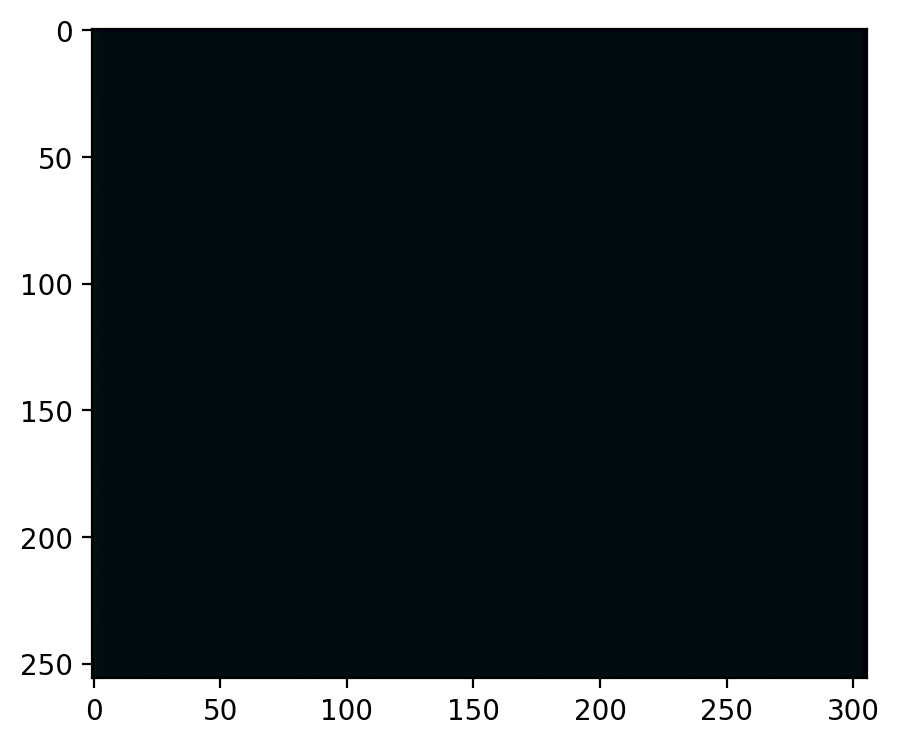

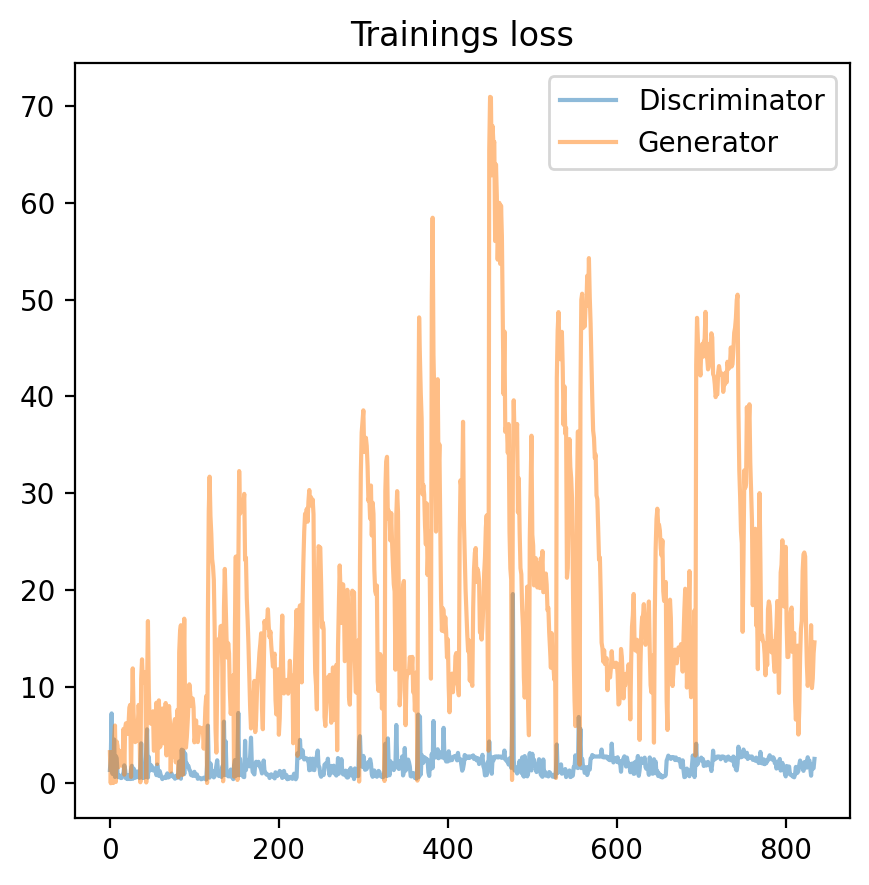

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1, Batch: 0, D-Loss: 1.5077457427978516, G-Loss: 13.803956985473633


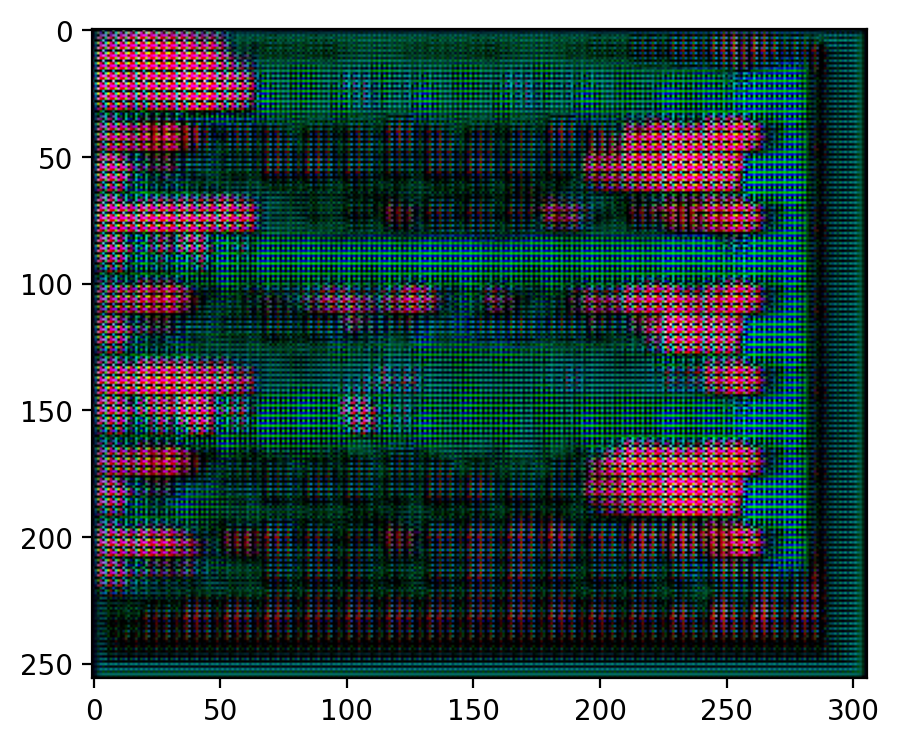

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2, Batch: 0, D-Loss: 30.39412498474121, G-Loss: 0.0


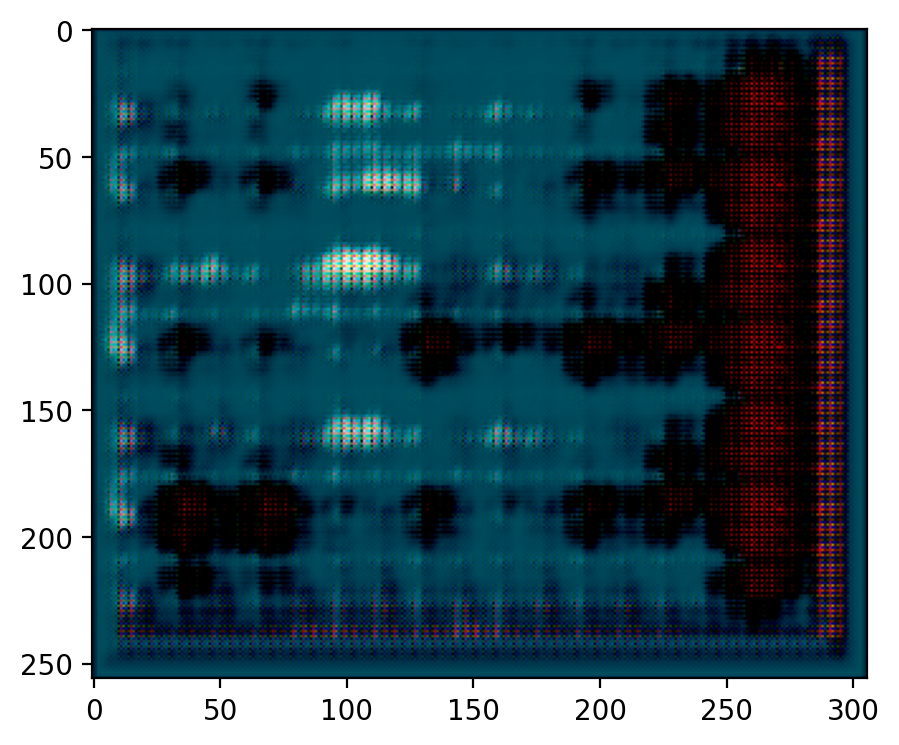

Epoch: 3, Batch: 0, D-Loss: 2.7631027698516846, G-Loss: 62.55217742919922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


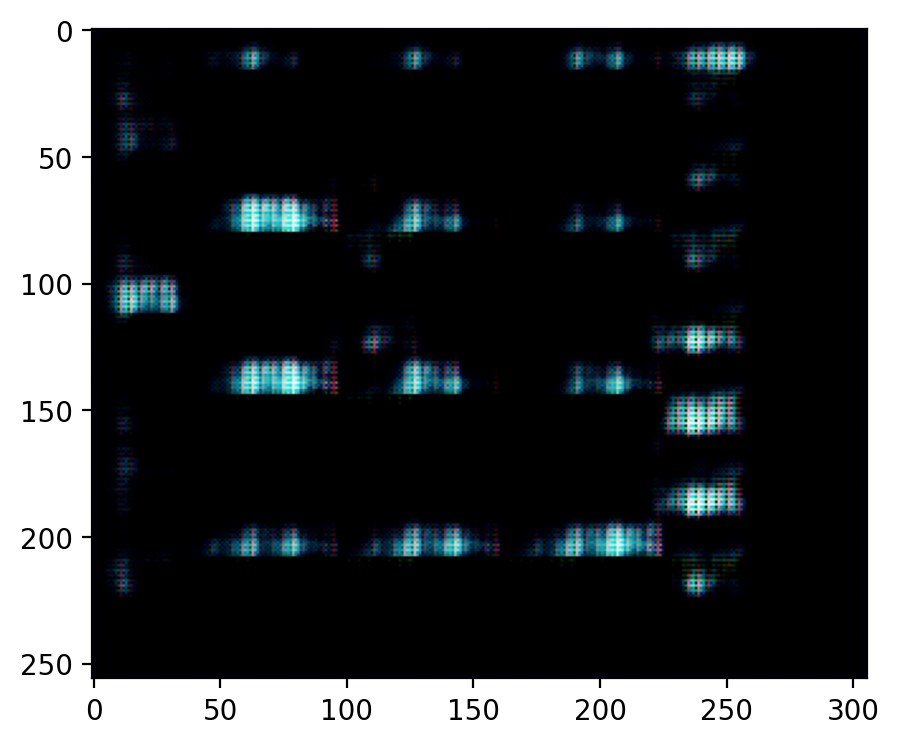

Epoch: 4, Batch: 0, D-Loss: 2.7631027698516846, G-Loss: 46.394371032714844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


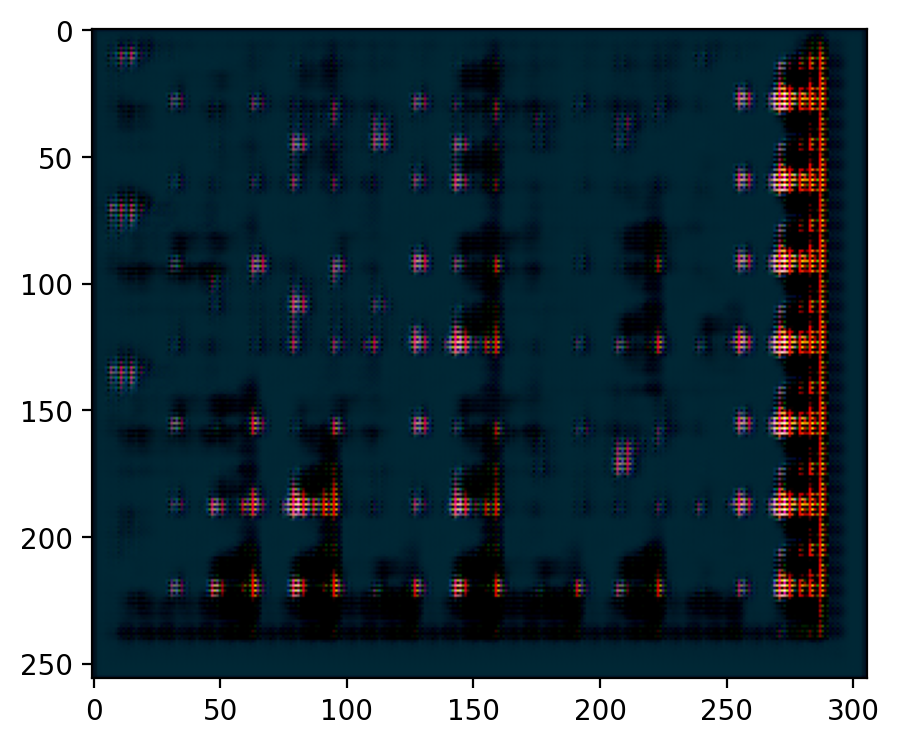

Epoch: 5, Batch: 0, D-Loss: 2.7631027698516846, G-Loss: 53.61559295654297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


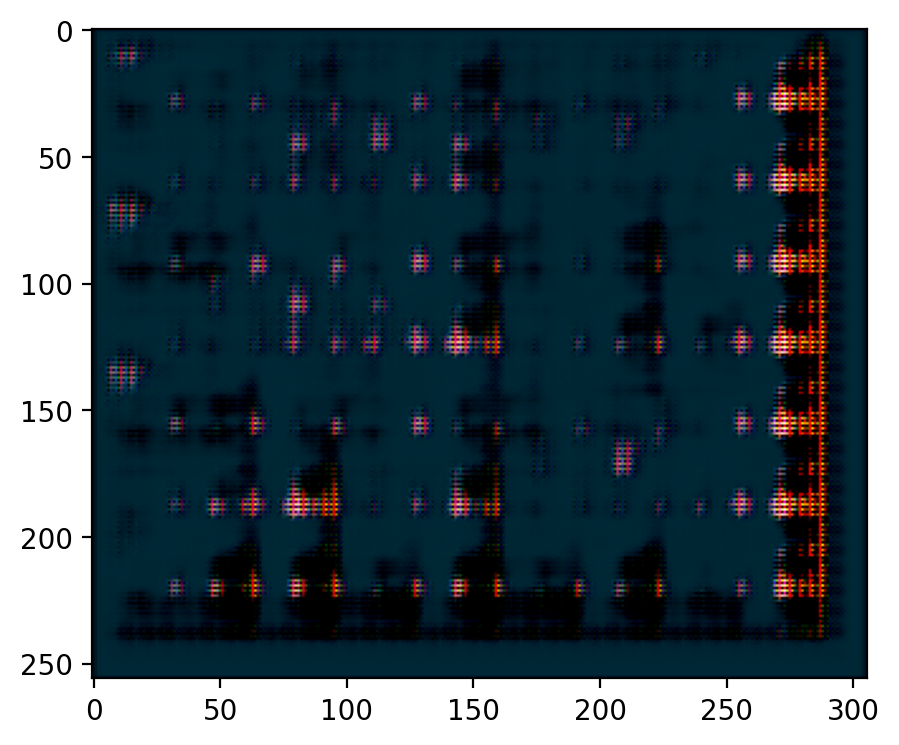

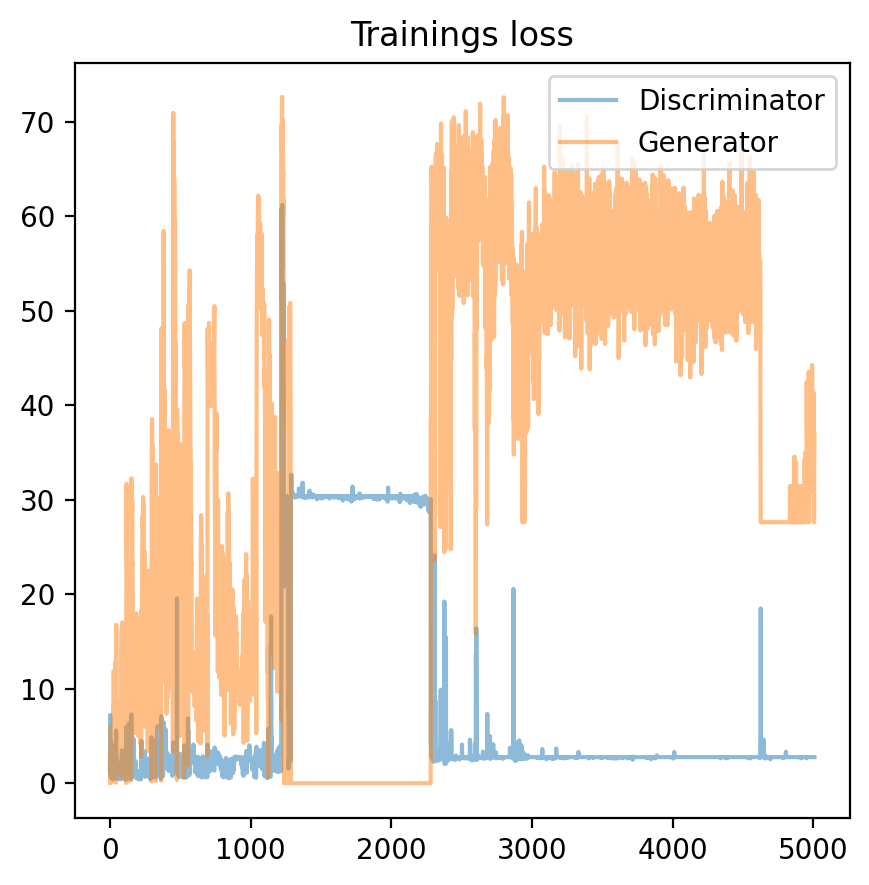

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 6, Batch: 0, D-Loss: 2.7631027698516846, G-Loss: 37.00503921508789


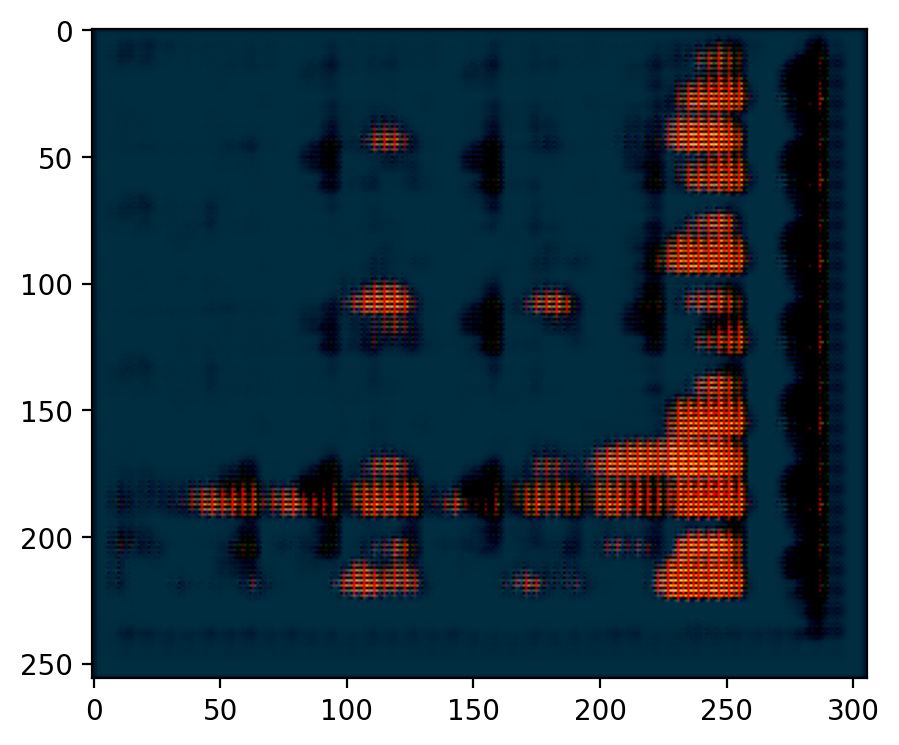

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7, Batch: 0, D-Loss: 2.7631027698516846, G-Loss: 38.04308319091797


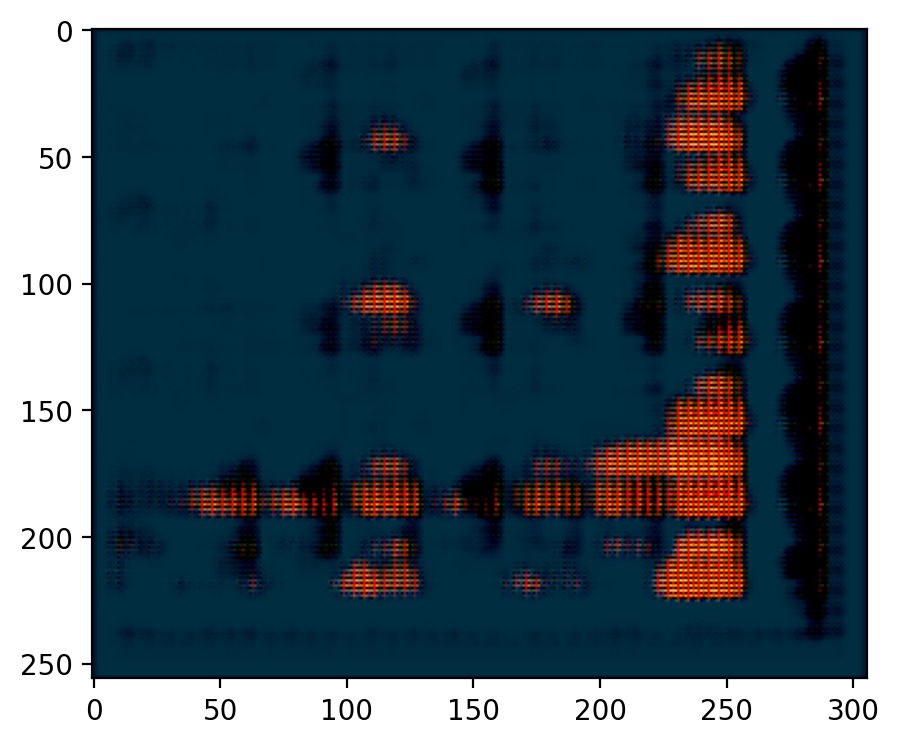

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8, Batch: 0, D-Loss: 2.7631027698516846, G-Loss: 34.39151382446289


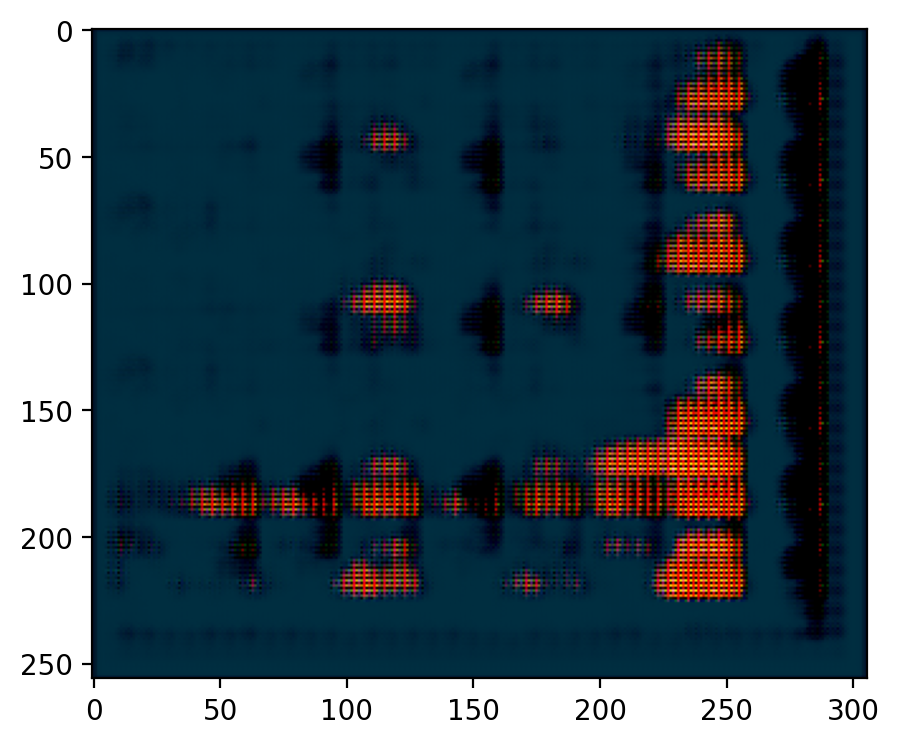

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9, Batch: 0, D-Loss: 2.7631027698516846, G-Loss: 31.37234115600586


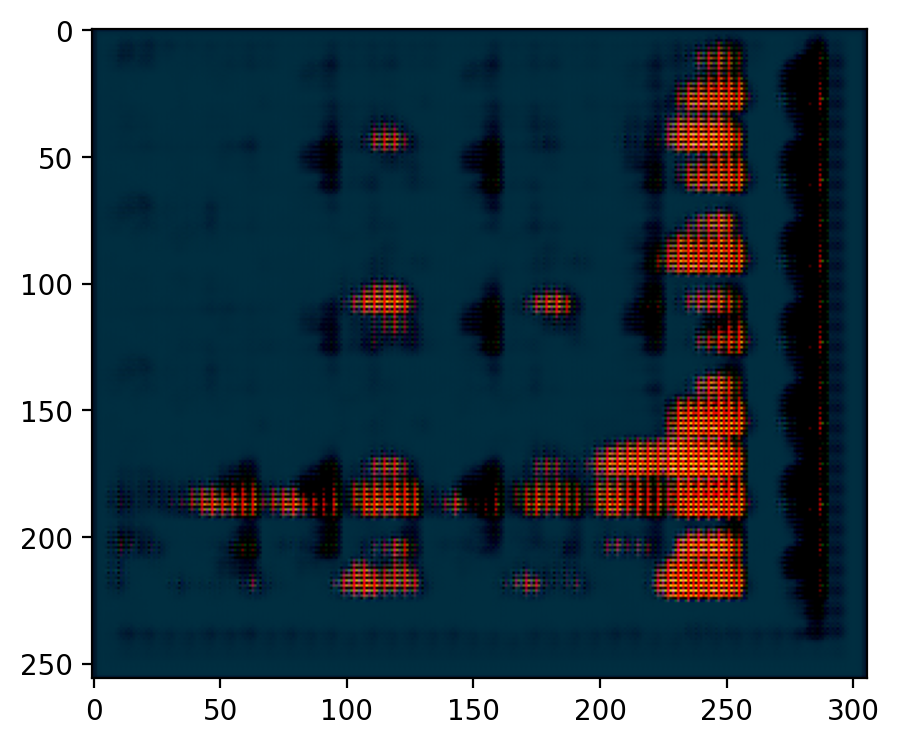

In [20]:
epochs = 100
# After how many batches should generated sample images be shown?
print_every = 1000
# How many images should be shown?
sample_size = 8
# After how many epochs should the loss be plotted?
plot_every = 5
# Create some sample noise
sample_noise = random_vector(sample_size, z_dim)
#-------------------------

# Keep track of losses
d_losses = []
g_losses = []

for e in range(epochs):
    for batch_idx, sample in enumerate(trainloader):
    #for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        # send to device
        #sample = torch.stack(sample).reshape(6,-1,3,256,306)
        sample = sample.to(device)
        batch_size = sample.shape[0]
        
        input_idx = np.random.randint(low=0, high=6, size=1)
        sample = sample[:,input_idx,:,:,:].squeeze()
        
        # Move images to GPU if available
        sample = sample.to(device)
        # Train discriminator
        d_loss = train_discriminator(G, D, d_optimizer, sample, batch_size, z_dim)
        # Train generator
        g_loss = train_generator(G, D, g_optimizer, batch_size, z_dim)
        
        # Keep track of losses
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        # Print some sample pictures
        if (batch_idx % print_every == 0):
            print("Epoch: {}, Batch: {}, D-Loss: {}, G-Loss: {}".format(e, batch_idx, d_loss, g_loss))
            # Make sample generation
            G.eval()
            # Generate predictions
            predictions = G.forward(sample_noise)
            plt.imshow(torchvision.utils.make_grid(predictions.reshape(-1,3,256,306)[0]).detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
    if (e % plot_every == 0):
        # Print losses
        plt.plot(d_losses, label="Discriminator", alpha=0.5)
        plt.plot(g_losses, label="Generator", alpha=0.5)
        plt.title("Trainings loss")
        plt.legend()
        plt.show()

## Get individual image

In [18]:
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=2, shuffle=True, num_workers=2)

In [19]:
# [batch_size, 3, H, W]
image, camera_index = iter(trainloader).next()
print(image.shape)

torch.Size([2, 3, 256, 256])


In [20]:
# Camera_index is to tell you which camera is used. The order is
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
print(camera_index[0])

tensor(2)


# Labeled dataset

In [16]:
batch_size = 16

In [17]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

trainloader = torch.utils.data.DataLoader(labeled_trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=2, 
                                          collate_fn=collate_fn)

labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

testloader = torch.utils.data.DataLoader(labeled_testset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=2, 
                                          collate_fn=collate_fn)

In [18]:
sample, target, road_image, extra = iter(trainloader).next()

There are two kind of labels

 1. The bounding box of surrounding objects
 2. The binary road_image

In [19]:
len(sample)

16

In [20]:
n_feature = 20

In [22]:
torch.stack(road_image).shape

torch.Size([16, 800, 800])

In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 bias = True, 
                 pool=False,
                 mp_kernel_size=2, 
                 mp_stride=2):
        super(ConvLayer, self).__init__()
        if pool:
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU(), 
                nn.MaxPool2d(kernel_size=mp_kernel_size, stride=mp_stride))
        else:
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU(), 
                )
        
    def forward(self, x):
        return self.layer(x)

class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearLayer, self).__init__()
        self.layer = nn.Sequential(
            torch.nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(0.5),
            nn.LeakyReLU(negative_slope=0.1) ## nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer(x)

class ConvTLayer(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 output_padding=0, 
                 unpool=False,
                 mp_kernel_size=2, 
                 mp_stride=2):
        super(ConvTLayer, self).__init__()
        if unpool:
            self.layer = nn.Sequential(
                nn.ConvTranspose2d(in_channels, 
                                   out_channels, 
                                   kernel_size, 
                                   stride=stride, 
                                   padding=padding, 
                                   output_padding=output_padding, 
                                   bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU()
                nn.MaxUnpool2d(kernel_size=mp_kernel_size, stride=mp_stride)
            )
        else:
            self.layer = nn.Sequential(
                nn.ConvTranspose2d(in_channels, 
                                   out_channels, 
                                   kernel_size, 
                                   stride=stride, 
                                   padding=padding, 
                                   output_padding=output_padding, 
                                   bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU()
            )        
    def forward(self, x):
        return self.layer(x)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = ConvLayer(3,16)
        self.conv2 = ConvLayer(96,128)
        self.conv3 = ConvLayer(128,256)
        self.conv4 = ConvLayer(256,512)
        self.conv5 = ConvLayer(512,1024, padding=(1,0))
        
    def forward(self, x):
        x = [y for y in sample]
        x = [self.conv1(y) for y in x]
        x = torch.cat(x,axis=0).reshape(-1,6*16,127,152)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        return x

class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()
        self.conv1 = ConvLayer(3,96, stride=2)
        self.conv2 = ConvLayer(96,128, stride=2)
        self.conv3 = ConvLayer(128,256, stride=2)
        self.conv4 = ConvLayer(256,512, stride=2)
        self.conv5 = ConvLayer(512,1024, padding=(0,0))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder = Encoder()
        self.linear = nn.Linear(1024*7*7,1)
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.linear(x.reshape(-1,1024*7*7))
        return torch.sigmoid(x)

class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.encoder = Encoder1()
        self.linear = nn.Linear(1024*13*13,1)
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.linear(x.reshape(-1,1024*13*13))
        return torch.sigmoid(x)

def random_vector(batch_size, length):
    # Sample from a Gaussian distribution
    z_vec = torch.randn(batch_size, length, 1, 1).float()
    if torch.cuda.is_available():
        z_vec = z_vec.to(device)
    return z_vec

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convt1 = ConvTLayer(4096, 2048, stride=2)
        self.convt2 = ConvTLayer(2048, 1024, stride=2, output_padding=(0,0))
        self.convt3 = ConvTLayer(1024, 512, stride=2, padding=(1,1), output_padding=(1,1))
        self.convt4 = ConvTLayer(512, 256, stride=2, output_padding=(1,1))
        self.convt5 = ConvTLayer(256, 128, stride=2, output_padding=(1,1))
        self.convt6 = ConvTLayer(128, 96, stride=2, output_padding=(1,1))
        self.convt7 = ConvTLayer(96, 64, stride=2, output_padding=(1,1))
        self.convt8 = ConvTLayer(64, 32, stride=1, output_padding=(0,0))
        self.convt9 = ConvTLayer(32, 18, stride=1, padding=(1,1), output_padding=(0,0))
        
    def forward(self,z):
        z = self.convt1(z)
        z = self.convt2(z)
        z = self.convt3(z)
        z = self.convt4(z)
        z = self.convt5(z)
        z = self.convt6(z)
        z = self.convt7(z)
        z = self.convt8(z)
        z = self.convt9(z)
        return z

class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()
        self.convt1 = ConvTLayer(4096, 2048, stride=2)
        self.convt2 = ConvTLayer(2048, 1024, stride=2, output_padding=(1,1))
        self.convt3 = ConvTLayer(1024, 512, stride=2, padding=(1,1), output_padding=(0,0))
        self.convt4 = ConvTLayer(512, 256, stride=2, output_padding=(0,0))
        self.convt5 = ConvTLayer(256, 128, stride=2, output_padding=(0,0))
        self.convt6 = ConvTLayer(128, 96, stride=2, output_padding=(0,0))
        self.convt7 = ConvTLayer(96, 3, stride=2, output_padding=(1,1))
        
    def forward(self,z):
        z = self.convt1(z)
        z = self.convt2(z)
        z = self.convt3(z)
        z = self.convt4(z)
        z = self.convt5(z)
        z = self.convt6(z)
        z = self.convt7(z)
        return z

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.decoder = Decoder()
        
    def forward(self,x):
        x = self.decoder(x)
        return torch.tanh(x).reshape(6,-1,3,256,256)

class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        self.decoder = Decoder1()
        
    def forward(self,x):
        x = self.decoder(x)
        return torch.tanh(x)

In [35]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.y_encoder = nn.Sequential(
            nn.Linear(3*256*256, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d)
        )

        self.x_encoder = nn.Sequential(
            nn.Linear(800*800, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.x_decoder = nn.Sequential(
            nn.Linear(2*d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 800*800),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, y):
        mu_logvar = self.x_encoder(x.view(-1, 800*800)).view(-1, 2, d)
        img_enc = self.y_encoder(y.view(-1, 3*256*256))
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        out = torch.cat((z,img_enc),axis=1)
        return self.x_decoder(out), mu, logvar
    

In [36]:
    
model = VAE().to(device)
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [43]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 800*800), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

In [38]:
torch.stack(sample).reshape(6,-1,3,256,256)[0].to(device).shape

torch.Size([16, 3, 256, 256])

In [39]:
torch.stack(road_image).shape

torch.Size([16, 800, 800])

In [40]:
pred = model(1.0*torch.stack(road_image).to(device),
             torch.stack(sample).reshape(6,-1,3,256,256)[0].to(device))

torch.Size([16, 20])
torch.Size([16, 20])
torch.Size([16, 40])


In [44]:
x_hat, mu, logvar = pred
loss = loss_function(x_hat, 1.0*torch.stack(road_image).to(device), mu, logvar)
print(loss.item())
# ===================backward====================
optimizer.zero_grad()
loss.backward()
optimizer.step()

7139694.0


RuntimeError: CUDA out of memory. Tried to allocate 300.00 MiB (GPU 0; 7.93 GiB total capacity; 7.32 GiB already allocated; 104.56 MiB free; 7.35 GiB reserved in total by PyTorch)

In [ ]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

In [22]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class CDAutoEncoder(nn.Module):
    r"""
    Convolutional denoising autoencoder layer for stacked autoencoders.
    This module is automatically trained when in model.training is True.

    Args:
        input_size: The number of features in the inputa
        output_size: The number of features to output
        stride: Stride of the convolutional layers.
    """
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoder, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=2, stride=stride, padding=0),
            nn.ReLU(),
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size, input_size, kernel_size=2, stride=2, padding=0), 
            nn.ReLU(),
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, x):
        # Train each autoencoder individually
        x = x.detach()
        # Add noise, but use the original lossless input as the target.
        x_noisy = x * (Variable(x.data.new(x.size()).normal_(0, 0.1)) > -.1).type_as(x)
        y = self.forward_pass(x_noisy)

        if self.training:
            x_reconstruct = self.backward_pass(y)
            loss = self.criterion(x_reconstruct, Variable(x.data, requires_grad=False))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return y.detach()

    def reconstruct(self, x):
        return self.backward_pass(x)


class StackedAutoEncoder(nn.Module):
    """
    A stacked autoencoder made from the convolutional denoising autoencoders above.
    Each autoencoder is trained independently and at the same time.
    """

    def __init__(self):
        super(StackedAutoEncoder, self).__init__()

        self.ae1 = CDAutoEncoder(3, 128, 2)
        self.ae2 = CDAutoEncoder(128, 256, 2)
        self.ae3 = CDAutoEncoder(256, 512, 2)
        self.ae3 = CDAutoEncoder(512, 1024, 2)
        self.ae3 = CDAutoEncoder(1024, 2048, 2)

    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)
        a4 = self.ae4(a3)
        a5 = self.ae4(a4)

        if self.training:
            return a5

        else:
            return a5, self.reconstruct(a5)

    def reconstruct(self, x):
        a4_reconstruct = self.ae5.reconstruct(x)
        a3_reconstruct = self.ae4.reconstruct(x)
        a2_reconstruct = self.ae3.reconstruct(x)
        a1_reconstruct = self.ae2.reconstruct(a2_reconstruct)
        x_reconstruct = self.ae1.reconstruct(a1_reconstruct)
        return x_reconstruct

model = StackedAutoEncoder()
#model = StackedAutoEncoder().to(device)

In [27]:
num_epochs = 10

for epoch in range(num_epochs):
    if epoch % 10 == 0:
        # Test the quality of our features with a randomly initialzed linear classifier.
        classifier = nn.Sequential(nn.Linear(6*2056*4*4, 1000),
                                  nn.ReLU(),
                                  nn.Linear(1000, 800*800)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    model.train()
    total_time = time.time()
    correct = 0
    for i, data in enumerate(trainloader):
        sample, target, road_image, extra = data
        road_image = 1*torch.stack(road_image).to(device).reshape(-1,800*800)
        batch_size = road_image.size(0)
        sample = torch.stack(sample).reshape(6,-1,3,256,256).to(device)
        features = []
        for img in sample:
            features.append(model(img).detach().view(features.size(0), -1))
        features = torch.cat(features, axis=1)
        prediction = classifier(features)
        loss = criterion(prediction, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = prediction.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    total_time = time.time() - total_time

    model.eval()
    img, _ = data
    img = Variable(img).cuda()
    features, x_reconstructed = model(img)
    reconstruction_loss = torch.mean((x_reconstructed.data - img.data)**2)

    if epoch % 10 == 0:
        print("Saving epoch {}".format(epoch))
        orig = to_img(img.cpu().data)
        save_image(orig, './imgs/orig_{}.png'.format(epoch))
        pic = to_img(x_reconstructed.cpu().data)
        save_image(pic, './imgs/reconstruction_{}.png'.format(epoch))

    print("Epoch {} complete\tTime: {:.4f}s\t\tLoss: {:.4f}".format(epoch, total_time, reconstruction_loss))
    print("Feature Statistics\tMean: {:.4f}\t\tMax: {:.4f}\t\tSparsity: {:.4f}%".format(
        torch.mean(features.data), torch.max(features.data), torch.sum(features.data == 0.0)*100 / features.data.numel())
    )
    print("Linear classifier performance: {}/{} = {:.2f}%".format(correct, len(dataloader)*batch_size, 100*float(correct) / (len(dataloader)*batch_size)))
    print("="*80)

torch.save(model.state_dict(), './CDAE.pth')

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [28]:
class Encoder(nn.Module):
    def __init__(self,n_feature, hidden):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                           out_channels=n_feature, 
                           kernel_size=(3,5), 
                           stride=2)
        self.maxp1 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,5), 
                               stride=1,
                               padding=(0,0))
        self.maxp2 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(3,3), 
                               stride=1,
                               padding=(0,0))
        self.maxp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv3_bn = nn.BatchNorm2d(96)
        
        self.lin1 = nn.Linear(96*14*16,hidden)
        self.lin1_bn = nn.BatchNorm1d(hidden)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.maxp1(self.conv1(y)))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.maxp1(self.conv2(x))))
        x = F.relu(self.conv3_bn(self.maxp1(self.conv3(x))))
        x = F.relu(self.lin1_bn(self.lin1(x.reshape(-1,96*14*16))))
        return x

In [29]:
class Decoder(nn.Module):
    def __init__(self, hidden, hidden_img):
        super(Decoder, self).__init__()
        self.hidden_img = hidden_img

        self.lin1 = nn.Linear(hidden,6*3*hidden_img*int(1.2*(hidden_img)))
        self.lin1_bn = nn.BatchNorm1d(6*3*hidden_img*int(1.2*(hidden_img)))

        self.convT1 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (3,4),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))
        
        self.convT1_bn = nn.BatchNorm2d(3)

        self.convT2 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (3,3),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))
        
        self.convT2_bn = nn.BatchNorm2d(3)

        self.convT3 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (2,1),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(1,1))
        
    def forward(self, x, verbose=False):
        x = F.relu(self.lin1_bn(self.lin1(x)).reshape(6,-1,3,hidden_img,int(1.2*hidden_img)))
        x = [y for y in x]
        x = [self.convT3(
            self.convT2_bn(self.convT2(
            self.convT1_bn(self.convT1(y))))) for y in x]
        x = tuple(x)
        x = torch.stack(x)
        return x

In [30]:
class Autoencoder(nn.Module):
    def __init__(self, n_features=32, hidden=1000, hidden_img=36):
        super().__init__()
        self.encoder = Encoder(n_features, hidden)
        self.decoder = Decoder(hidden, hidden_img)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(epoch, model, criterion, optimizer, batch_size,show_photo=False):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        img = sample 
        img = img.to(device)
        # img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape))
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    plt_out = output.reshape(-1,6,3,256,306)
    plt.imshow(torchvision.utils.make_grid(plt_out[0].detach().cpu()
                                           , nrow=3).numpy().transpose(1, 2, 0))
    plt.show()

In [ ]:
convT1 = nn.ConvTranspose2d(in_channels=128, 
                                 out_channels=96, 
                                 kernel_size=1, 
                                 padding = (2,2),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

## convT1(x).shape ## can add conv3(x) as a skip connection here

convT2 = nn.ConvTranspose2d(in_channels=96, 
                                 out_channels=96, 
                                 kernel_size=1, 
                                 padding = (4,4),
                                 stride = 3, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

convT3 = nn.ConvTranspose2d(in_channels=96, 
                                 out_channels=96, 
                                 kernel_size=3, 
                                 padding = (2,2),
                                 stride = 2, 
                                 dilation=(1,1),
                                 output_padding=(1,1))

convT4 = nn.ConvTranspose2d(in_channels=96, 
                                 out_channels=64, 
                                 kernel_size=2, 
                                 padding = (0,0),
                                 stride = 2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

convT5 = nn.ConvTranspose2d(in_channels=64, 
                                 out_channels=2, 
                                 kernel_size=2, 
                                 padding = (0,0),
                                 stride = 2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

In [ ]:
class SemSeg(nn.Module):
    def __init__(self,n_feature):
        super(SemSeg, self).__init__()
        self.conv1 = conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=2, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv3 = nn.Conv2d(in_channels=2, 
                               out_channels=2, 
                               kernel_size=(1,5), 
                               stride=2,
                               padding=(2,0))
        self.conv4 = nn.Conv2d(in_channels=2, 
                               out_channels=2, 
                               kernel_size=(1,1), 
                               stride=2,
                               padding=(2,2))
        self.convT1 = nn.ConvTranspose2d(in_channels=2, 
                                         out_channels=2, 
                                         kernel_size=1, 
                                         stride=42, 
                                         dilation=1,
                                         output_padding=1)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [self.conv1(y) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.convT1(x)
        return x

In [ ]:
class SemSegMulti(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMulti, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=50, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv3 = nn.Conv2d(in_channels=50, 
                               out_channels=25, 
                               kernel_size=(1,5), 
                               stride=2,
                               padding=(2,0))
        self.conv4 = nn.Conv2d(in_channels=25, 
                               out_channels=15, 
                               kernel_size=(1,1), 
                               stride=2,
                               padding=(2,2))
        self.convT1 = nn.ConvTranspose2d(in_channels=15, 
                                         out_channels=10, 
                                         kernel_size=1, 
                                         stride=42, 
                                         dilation=1,
                                         output_padding=1)
        self.convT2 = nn.ConvTranspose2d(in_channels=15, 
                                         out_channels=2, 
                                         kernel_size=1, 
                                         stride=42, 
                                         dilation=1,
                                         output_padding=1)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [self.conv1(y) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return [self.convT1(x),
                self.convT2(x)]

In [ ]:
class SemSegMulti2(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMulti2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6_bn = nn.BatchNorm2d(128)
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT1_bn = nn.BatchNorm2d(96)
        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT2_bn = nn.BatchNorm2d(96)
        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))
        self.convT3_bn = nn.BatchNorm2d(96)
        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT4_bn = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=10, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x1 = F.relu(self.conv6_bn(self.conv6(x1)))
        x1 = F.relu(self.convT1_bn(self.convT1(x1))) + x
        return [
            self.convT6(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            ))))),
            self.convT5(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            )))))
            ]

In [ ]:
class SemSegMultiBB(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMultiBB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6_bn = nn.BatchNorm2d(128)
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT1_bn = nn.BatchNorm2d(96)
        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT2_bn = nn.BatchNorm2d(96)
        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))
        self.convT3_bn = nn.BatchNorm2d(96)
        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT4_bn = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x1 = F.relu(self.conv6_bn(self.conv6(x1)))
        x1 = F.relu(self.convT1_bn(self.convT1(x1))) + x
        return [
            self.convT6(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            ))))),
            self.convT5(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            )))))
            ]

In [ ]:
class SemSegMultiBB2(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMultiBB2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6_bn = nn.BatchNorm2d(128)
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT1_bn = nn.BatchNorm2d(96)
        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT2_bn = nn.BatchNorm2d(96)
        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))
        self.convT3_bn = nn.BatchNorm2d(96)
        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT4_bn = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x1 = F.relu(self.conv6_bn(self.conv6(x1)))
        x1 = F.relu(self.convT1_bn(self.convT1(x1))) + x
        return [
            self.convT6(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            ))))),
            self.convT5(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            )))))
            ]

In [ ]:
class SemSegVAE(nn.Module):
    def __init__(self,n_feature):
        super(SemSegVAE, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))

        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=10, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [self.conv1(y) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = self.conv2(x)
        x = self.conv3(x)
        x1 = self.conv4(x)
        x1 = self.conv5(x1)
        x1 = self.conv6(x1)
        x1 = self.convT1(x1) + x
        return [self.convT6(self.convT4(self.convT3(self.convT2(x1)))),
                self.convT5(self.convT4(self.convT3(self.convT2(x1))))]

In [ ]:
def train(epoch, model, criterion, optimizer, batch_size):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        output = model(sample)        
        optimizer.zero_grad()
        loss = criterion(output, road_image)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(sample), len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * len(sample) / len(trainloader.dataset), 
                loss.item()))

In [ ]:
accuracy_list = []
def test(model, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        
        output = model(sample) 
        test_loss += criterion(output, road_image).item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(road_image.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(testloader.dataset)
    accuracy = 100. * correct / (16*800*800*len(testloader))
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, (batch_size*800*800*len(testloader)),
        accuracy))

In [ ]:
def trainMulti(epoch, model, criterion1, criterion2, optimizer, batch_size):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,10,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,cat+1,:,:] += 1*convert_to_binary_mask(bb)
        y_target = y_target.to(device)
        values, indices = torch.max(y_target,1)
        y_target = torch.max(y_target,1, keepdim=True)
        y_targ = torch.zeros_like(values, dtype=torch.long)
        y_targ[values > 0] = indices[values > 0]
        y_target = y_targ
        output = model(sample) 
        optimizer.zero_grad()
        #print(y_target.unique())
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * batch_size, len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * batch_size / len(trainloader.dataset), 
                loss.item()))

accuracy_list = []
def testMulti(model, criterion1, criterion2):
    model.eval()
    test_loss = 0
    road_correct = 0
    other_correct = 0
    total_road = 0
    total_other = 0
    conf_matrix_road = torch.zeros(2, 2)
    conf_matrix_other = torch.zeros(10, 10)
    for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,10,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,cat+1,:,:] += 1*convert_to_binary_mask(bb)
        y_target = y_target.to(device)
        values, indices = torch.max(y_target,1)
        y_target = torch.max(y_target,1, keepdim=True)
        y_targ = torch.zeros_like(values, dtype=torch.long)
        y_targ[values > 0] = indices[values > 0]
        y_target = y_targ
        
        output = model(sample)
        
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        
        test_loss += loss.item() # sum up batch loss                                                               
        pred_road = output[1].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        pred_other = output[0].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        road_correct += pred_road.eq(road_image.data.view_as(pred_road)).cpu().sum().item()
        other_correct += pred_other.eq(y_target.data.view_as(pred_other)).cpu().sum().item()
        total_road += road_image.nelement()
        total_other += y_target.nelement()
                
        conf_matrix_road = create_conf_matrix2(road_image, pred_road)
        conf_matrix_other = create_conf_matrix2(y_target, pred_other)
                
    test_loss /= len(testloader.dataset)
    road_accuracy = 100. * road_correct / total_road
    other_accuracy = 100. * other_correct / total_other
    accuracy_list.append((road_accuracy + other_accuracy)/2)
    print("""\nTest set: Average loss: {:.4f}, 
    Accuracy Road: {}/{} ({:.0f}%) , 
    Accuracy Other: {}/{}, ({:.0f}%),
    Road: TP {} , 
    TN {}
    FP {}
    FN {},
    Other: TP {} 
    TN {} 
    FP {}
    FN {}
    \n""".format(
        test_loss, road_correct, total_road, road_accuracy,
        other_correct, total_other, other_accuracy, 
        *classScores(conf_matrix_road),
        *classScores(conf_matrix_other)))
    
        

In [ ]:
weights1 = [0.1, 1.0]
class_weights1 = torch.FloatTensor(weights1).cuda()

criterion1 = nn.CrossEntropyLoss(reduction='mean',weight=class_weights1)

weights = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
class_weights = torch.FloatTensor(weights).cuda()
criterion2 = nn.CrossEntropyLoss(reduction='mean')
model = SemSegMulti2(32)
model.to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 50):
    trainMulti(epoch, model, criterion1, criterion2, optimizer, batch_size)
    testMulti(model, criterion1, criterion2)
    scheduler.step(accuracy_list[epoch])

In [ ]:
def trainBB(epoch, model, criterion1, criterion2, optimizer, batch_size):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,1,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,0,:,:] += 1*convert_to_binary_mask(bb)
        y_target = 1*(y_target>0)
        y_target = y_target.to(device).squeeze()
        output = model(sample) 
        optimizer.zero_grad()
        #print(y_target.unique())
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * batch_size, len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * batch_size / len(trainloader.dataset), 
                loss.item()))

accuracy_list = []
def testBB(model, criterion1, criterion2):
    model.eval()
    test_loss = 0
    road_correct = 0
    other_correct = 0
    total_road = 0
    total_other = 0
    conf_matrix_road = torch.zeros(2, 2)
    conf_matrix_other = torch.zeros(10, 10)
    for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,1,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,0,:,:] += 1*convert_to_binary_mask(bb)
        y_target = 1*(y_target>0)
        y_target = y_target.to(device).squeeze()
        
        output = model(sample)
        
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        
        test_loss += loss.item() # sum up batch loss                                                               
        pred_road = output[1].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        pred_other = output[0].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        road_correct += pred_road.eq(road_image.data.view_as(pred_road)).cpu().sum().item()
        other_correct += pred_other.eq(y_target.data.view_as(pred_other)).cpu().sum().item()
        total_road += road_image.nelement()
        total_other += y_target.nelement()
                
        conf_matrix_road = create_conf_matrix2(road_image, pred_road)
        conf_matrix_other = create_conf_matrix2(y_target, pred_other)
                
    test_loss /= len(testloader.dataset)
    road_accuracy = 100. * road_correct / total_road
    other_accuracy = 100. * other_correct / total_other
    accuracy_list.append((road_accuracy + other_accuracy)/2)
    print("""\nTest set: Average loss: {:.4f}, 
    Accuracy Road: {}/{} ({:.0f}%) , 
    Accuracy Other: {}/{}, ({:.0f}%),
    Road: TP {} , 
    TN {}
    FP {}
    FN {},
    Other: TP {} 
    TN {} 
    FP {}
    FN {}
    \n""".format(
        test_loss, road_correct, total_road, road_accuracy,
        other_correct, total_other, other_accuracy, 
        *classScores(conf_matrix_road),
        *classScores(conf_matrix_other)))
    

weights1 = [0.6, 1.0]
class_weights1 = torch.FloatTensor(weights1).cuda()

criterion1 = nn.CrossEntropyLoss(reduction='mean',weight=class_weights1)

weights2 = [0.02, 1.0]
class_weights2 = torch.FloatTensor(weights2).cuda()
criterion2 = nn.CrossEntropyLoss(reduction='mean',weight=class_weights2)
model = SemSegMultiBB(32)
model.to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 50):
    trainBB(epoch, model, criterion1, criterion2, optimizer, batch_size)
    testBB(model, criterion1, criterion2)
    scheduler.step(accuracy_list[epoch])

In [ ]:
sample, target, road_image, extra = iter(testloader).next()

In [ ]:
y_target = torch.zeros((batch_size,1,800,800))
for i in range(batch_size):
    for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
        y_target[i,0,:,:] += 1*convert_to_binary_mask(bb)

In [ ]:
(y_target>0).sum()

In [ ]:
y_target = y_target>0

In [ ]:
for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
    print(batch_idx, target[0]['category'])
    batch_size = 1
    y_target = torch.zeros((batch_size,9,800,800))
    for i in range(batch_size):
        for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
            y_target[i,cat+1,:,:] += 1*convert_to_binary_mask(bb)
            print(i, cat, y_target[i,cat+1,:,:].sum())
    y_target = y_target.to(device)
    values, indices = torch.max(y_target,1)
    y_target = torch.max(y_target,1, keepdim=True)
    y_targ = torch.zeros_like(values, dtype=torch.long)
    y_targ[values > 0] = indices[values > 0]
    print(y_targ)
    print(y_targ.sum())
    break

In [ ]:
# The shape of bounding box is [batch_size, N (the number of object), 2, 4]
print(target[0]['bounding_box'].shape)

In [ ]:
# All bounding box are retangles
# Each bounding box is organized with four corners of the box
# All the values are in meter and bounded by 40 meters, and the origin is the center of ego car
# the order of the four courners are front left, front right, back left and back right
print(target[0]['bounding_box'][0])

In [ ]:
corners = target[0]['bounding_box'][11]

In [ ]:
corners

In [ ]:
point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
x,y = point_squence.T[0].detach() * 10 + 400, -point_squence.T[1].detach() * 10 + 400

In [ ]:
plt.figure()

for i, bb in enumerate(target[0]['bounding_box']):
    ax= plt.subplot(6,5 ,i+1)
    new_im = convert_to_binary_mask(bb)
    ax.imshow(new_im, cmap='binary')

In [ ]:
list(zip(x,y))

In [ ]:
# Each bounding box has a category
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8
print(target[0]['category'])

In [ ]:
sem_seg_target = np.zeros((10,800,800))

for cat, bb in zip(target[0]['category'], target[0]['bounding_box']):
    sem_seg_target[cat,:,:] += convert_to_binary_mask(bb)

In [ ]:
plt.figure()
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(sem_seg_target[i,:,:]==1, cmap='binary')

## Road Map Layout


In [ ]:
road_image[0]

In [ ]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

In [ ]:
print(road_image[0].shape)

In [ ]:
print(road_image[0])

## Extra Info

There is some extra information you can use in your model, but it is optional.

In [ ]:
# Action
# Action is the label that what the object is doing

# 'object_action_parked': 0,
# 'object_action_driving_straight_forward': 1,
# 'object_action_walking': 2,
# 'object_action_running': 3,
# 'object_action_lane_change_right': 4,
# 'object_action_stopped': 5,
# 'object_action_left_turn': 6,
# 'object_action_right_turn': 7,
# 'object_action_sitting': 8,
# 'object_action_standing': 9,
# 'object_action_gliding_on_wheels': 10,
# 'object_action_abnormal_or_traffic_violation': 11,
# 'object_action_lane_change_left': 12,
# 'object_action_other_motion': 13,
# 'object_action_reversing': 14,
# 'object_action_u_turn': 15,
# 'object_action_loss_of_control': 16

In [ ]:
print(extra[0]['action'])

In [ ]:
# Ego Image
# A more detailed ego image
fig, ax = plt.subplots()

ax.imshow(extra[0]['ego_image'].numpy().transpose(1, 2, 0));

In [ ]:
# Lane Image
# Binary lane image
fig, ax = plt.subplots()

ax.imshow(extra[0]['lane_image'], cmap='binary');

# Visualize the bounding box

In [ ]:
target[0]

In [ ]:
target[0]['bounding_box']

In [ ]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

## Object Detection

In [ ]:
class ObjDet(nn.Module):
    def __init__(self,n_feature, n_categories, n_boxes):
        super(ObjDet, self).__init__()
        self.n_categories = n_categories
        self.n_boxes = n_boxes
        self.conv1 = conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,5), 
                               stride=2,
                               padding=(2,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=96, 
                               kernel_size=(1,1), 
                               stride=2,
                               padding=(2,2))
        self.conv4_bn = nn.BatchNorm2d(96)
        self.lin2 = nn.Linear(96*20*20, self.n_boxes*8)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        return self.lin2(x.reshape(-1,96*20*20)).reshape(-1,2,self.n_boxes*4)

In [ ]:
n_cat = 10
n_boxes = 50
n_feature = 20

obj = ObjDet(n_feature, n_cat, n_boxes)

cat_prob, xy = obj(torch.stack(sample)[0].reshape(6,-1,3,256,306))

cat_prob = cat_prob.reshape(-1,n_cat)
cat_prob.shape

bb = xy.reshape(-1,2,4)
bb.shape

target_c = target[0]['category']
print(target_c.shape)
target_bb = target[0]['bounding_box'].reshape(-1,2,4)
print(target_bb.shape)

bb[0,:,:] = target_bb[3,:,:]
bb[1,:,:] = target_bb[1,:,:]

sample, target, road_image, extra = iter(trainloader).next()

sample = torch.stack(sample)

sample = sample.reshape(6,-1,3,256,306)

batch_size = sample.size(1)

pred = obj(sample)

pred = tuple(zip(pred[0].reshape(batch_size,-1,10), pred[1].reshape(batch_size,-1,2,4)))

targ = tuple([(targ_i['category'],targ_i['bounding_box']) for targ_i in target])

loss = ssd_loss(pred,targ)
loss.backward()
optimizer.step()

In [ ]:
def trainObjDet(epoch, model, optimizer):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        batch_size = sample.size(1)
        pred = model(sample)
        pred = tuple([bb for bb in pred.reshape(batch_size,-1,2,4)])
        targ = tuple([targ_i['bounding_box'].to(device) for targ_i in target])
        loss = ssd_loss(pred,targ)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(sample), len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * len(sample) / len(trainloader.dataset), 
                loss.item()))

In [ ]:
n_cat = 10
n_boxes = 50
n_feature = 20


def ssd_1_loss(b_bb,
               bbox,
               print_it=False):
    overlaps = calculate_overlap(bbox.data, b_bb.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    #gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    #gt_clas[~pos] = n_cat
    gt_bbox = bbox[gt_idx]
    loc_loss = ((b_bb[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #clas_loss  = loss_f(b_c, gt_clas)
    #return loc_loss, clas_loss
    return loc_loss
    
def ssd_loss(pred,targ,print_it=False):
    lls = 0.
    for b, t in zip(pred,targ):
        b_bb = b
        bbox = t
        #print(b_c.shape,b_bb.shape)
        #print(clas.shape,bbox.shape)
        loc_loss = ssd_1_loss(b_bb,
                              bbox,
                              print_it)
        lls += loc_loss
    if print_it: print(f'loc: {lls.data[0]}')
    return lls

In [ ]:
model = ObjDet(n_feature, n_cat, n_boxes)
model.to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 5):
    trainObjDet(epoch, model, optimizer)
    #testObjDet(model, criterion, batch_size)
    #scheduler.step(accuracy_list[epoch])

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$
